In [ ]:
%load_ext autoreload
%autoreload 2

In [12]:
import torch
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import numpy as np
import json
from collections import defaultdict
import os

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda:0'

In [2]:
from kp.scripts.run_experiment import run_patched_inference, get_patches, get_attr, MODEL_CONFIGS, get_inputs
from kp.utils.utils_io import dict_to_namespace
from kp.train.model_factory import model_factory
from kp.utils.constants import MODEL_TO_HFID

In [3]:
BASE_EXPERIMENTS_DIR = "/net/projects/clab/tnief/bidirectional-reversal/experiments/"

In [44]:
def find_results_files(base_dir):
    """Recursively finds all 'results.json' files under the base_dir."""
    results_files = []
    print(f"Searching for 'results.json' files in: {base_dir}")
    for path in Path(base_dir).rglob("results.json"):
        if "archive" in str(path) or "smoke_test" in str(path):
            continue
        results_files.append(path)
    print(f"Found {len(results_files)} 'results.json' files.")
    return results_files

In [51]:
def parse_path(results_file_path: 'Path', base_dir: str): # results_file_path is a Path object
    """
    Parses the file path to extract experiment metadata.
    Expected path structure relative to base_dir:
    dataset/model/patch_direction/patch_type/run_id/sentence_id/dropout_rate/results.json
    """
    # Convert Path object to string for processing
    results_file_path_str = str(results_file_path) 

    try:
        # Ensure base_dir has a trailing slash for consistent processing.
        if not base_dir.endswith(os.path.sep):
            base_dir += os.path.sep
            
        # Now use the string version for startswith
        if not results_file_path_str.startswith(base_dir):
            print(f"Warning: File {results_file_path_str} is not under base_dir {base_dir}")
            return None

        # And for slicing and splitting
        relative_path = results_file_path_str[len(base_dir):]
        components = relative_path.split(os.path.sep)
        
        if len(components) == 8 and components[7] == "results.json":
            dataset = components[0]
            model = components[1]
            patch_direction = components[2]
            patch_type = components[3]
            run_id = components[4]
            sentence_id = components[5]
            dropout_rate = components[6] 

            
            return {
                "dataset": dataset,
                "model": model,
                "patch_direction": patch_direction,
                "patch_type": patch_type,
                "run_id": run_id,
                "sentence_id": sentence_id,
                "dropout_rate": dropout_rate,
                "full_path": results_file_path_str # Store string path
            }
        else:
            print(f"Warning: Path structure mismatch for {results_file_path_str}. Relative: '{relative_path}', Components: {len(components)} {components}")
            return None
    except Exception as e:
        # Use the string version in the error message too
        print(f"Error parsing path {results_file_path_str}: {e}")
        return None

In [52]:
def calculate_metrics_from_file(results_json_path, top_k=5):
    """
    Reads a results.json file and calculates metrics.
    Metrics: mean target rank, top-5 accuracy, mean target probability.
    Assumes target token rank is 1-indexed for top-5 accuracy (rank <= 5).
    """
    try:
        with open(results_json_path, 'r') as f:
            data = json.load(f)
    except Exception as e:
        print(f"Error reading or parsing {results_json_path}: {e}")
        return None # Indicates a file read/parse error

    if "results" not in data or not isinstance(data["results"], list):
        # print(f"Warning: 'results' key missing or not a list in {results_json_path}")
        return { # Return NaNs if structure is invalid but file was readable
            "mean_target_rank": float('nan'),
            "top_5_accuracy": float('nan'),
            "mean_target_prob": float('nan')
        }
    
    if not data["results"]: # Empty list of results
        return {
            "mean_target_rank": float('nan'),
            "top_5_accuracy": float('nan'),
            "mean_target_prob": float('nan')
        }

    target_ranks = []
    is_in_top_k = []
    target_probs = []

    for res_item in data["results"]:
        if "target" in res_item and isinstance(res_item["target"], dict):
            target_info = res_item["target"]
            
            if "token_rank" in target_info and isinstance(target_info["token_rank"], (int, float)):
                rank = target_info["token_rank"]
                target_ranks.append(rank)
                # Top-5: rank is 1, 2, 3, 4, or 5.
                is_in_top_k.append(1 if rank <= top_k and rank >=1 else 0) # Ensure rank is positive
            else:
                target_ranks.append(float('nan'))
                is_in_top_k.append(float('nan'))

            if "token_prob" in target_info and isinstance(target_info["token_prob"], (int, float)):
                target_probs.append(target_info["token_prob"])
            else:
                target_probs.append(float('nan'))
        else: # Target info missing for a result item
            target_ranks.append(float('nan'))
            is_in_top_k.append(float('nan'))
            target_probs.append(float('nan'))
    
    mean_rank = np.nanmean(target_ranks) if any(not np.isnan(r) for r in target_ranks) else float('nan')
    top_k_acc = np.nanmean(is_in_top_k) if any(not np.isnan(r) for r in is_in_top_k) else float('nan')
    mean_prob = np.nanmean(target_probs) if any(not np.isnan(r) for r in target_probs) else float('nan')
    
    return {
        "mean_target_rank": mean_rank,
        "top_k_accuracy": top_k_acc,
        "mean_target_prob": mean_prob
    }

In [53]:
from collections import defaultdict

def organize_results_by_dataset_model_sentence(all_results_files, base_dir):
    """
    Organizes results into a nested dictionary:
    top_level[dataset][model][sentence][patch] = metrics_dict
    """
    organized_data = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
    
    parsed_files_count = 0
    metrics_calculated_count = 0

    for file_path in all_results_files:
        parsed_info = parse_path(file_path, base_dir)
        if not parsed_info:
            # This file path didn't match the expected structure or couldn't be parsed.
            continue
        
        parsed_files_count += 1
        
        metrics = calculate_metrics_from_file(file_path)
        if metrics is None: 
            # Error reading or parsing the JSON content of this file.
            print(f"Skipping file due to content read/parse error: {file_path}")
            continue
        
        metrics_calculated_count += 1
            
        dataset = parsed_info["dataset"]
        model = parsed_info["model"]  # Changed to 'model'
        sentence_id = parsed_info["sentence_id"]
        patch_config = parsed_info["patch_type"]
        
        # New structure
        organized_data[dataset][model][sentence_id][patch_config] = metrics
        
    print(f"Attempted to parse paths for {len(all_results_files)} files.")
    print(f"Successfully parsed path metadata for {parsed_files_count} files.")
    print(f"Successfully calculated metrics for {metrics_calculated_count} files.")
    print(f"Organized data into {len(organized_data)} datasets.")
    
    for dataset_name, models in organized_data.items():
        print(f"  Dataset '{dataset_name}' has {len(models)} model configurations.")
    
    return organized_data

In [54]:
# Actually run this now
all_my_results_files = find_results_files(BASE_EXPERIMENTS_DIR)

Searching for 'results.json' files in: /net/projects/clab/tnief/bidirectional-reversal/experiments/
Found 150 'results.json' files.


In [55]:
all_my_results_files

[PosixPath('/net/projects/clab/tnief/bidirectional-reversal/experiments/fake_movies_real_actors/pythia-2.8b/sft2pre/fe/all_2025-05-08_12-10-29/checkpoint-26400_best_saved_checkpoint_2025-05-11_11-15-18/sentence_1/dropout_0.0_layer_count/results.json'),
 PosixPath('/net/projects/clab/tnief/bidirectional-reversal/experiments/fake_movies_real_actors/pythia-2.8b/sft2pre/fe_lt_complement/all_2025-05-08_12-10-29/checkpoint-26400_best_saved_checkpoint_2025-05-11_11-15-18/sentence_1/dropout_0.0_layer_count/results.json'),
 PosixPath('/net/projects/clab/tnief/bidirectional-reversal/experiments/fake_movies_real_actors/pythia-2.8b/sft2pre/no_patching/all_2025-05-08_12-10-29/checkpoint-26400_best_saved_checkpoint_2025-05-10_23-27-05/sentence_1/dropout_0.0_layer_count/results.json'),
 PosixPath('/net/projects/clab/tnief/bidirectional-reversal/experiments/fake_movies_real_actors/pythia-2.8b/sft2pre/no_patching/all_2025-05-08_12-10-29/checkpoint-26400_best_saved_checkpoint_2025-05-10_23-27-05/sentenc

In [56]:
data_by_sentence = organize_results_by_dataset_model_sentence(all_my_results_files, BASE_EXPERIMENTS_DIR)

Attempted to parse paths for 150 files.
Successfully parsed path metadata for 133 files.
Successfully calculated metrics for 133 files.
Organized data into 2 datasets.
  Dataset 'fake_movies_real_actors' has 3 model configurations.
  Dataset 'fake_movies_fake_actors' has 2 model configurations.


In [57]:
data_by_sentence

defaultdict(<function __main__.organize_results_by_dataset_model_sentence.<locals>.<lambda>()>,
            {'fake_movies_real_actors': defaultdict(<function __main__.organize_results_by_dataset_model_sentence.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'gpt2-xl': defaultdict(dict,
                                      {'sentence_1': {'fe_m_p_lt': {'mean_target_rank': 0.001001001001001001,
                                         'top_k_accuracy': 0.001001001001001001,
                                         'mean_target_prob': 0.9989431035351586},
                                        'fe_lt_complement': {'mean_target_rank': 645.6366366366366,
                                         'top_k_accuracy': 0.021021021021021023,
                                         'mean_target_prob': 0.0026432231637189036},
                                        'not_lt': {'mean_target_rank': 47.009009009009006,
                                         'top_k_accuracy': 0.2332

In [60]:
data_by_sentence['fake_movies_real_actors']['gpt2-xl']

defaultdict(dict,
            {'sentence_1': {'fe_m_p_lt': {'mean_target_rank': 0.001001001001001001,
               'top_k_accuracy': 0.001001001001001001,
               'mean_target_prob': 0.9989431035351586},
              'fe_lt_complement': {'mean_target_rank': 645.6366366366366,
               'top_k_accuracy': 0.021021021021021023,
               'mean_target_prob': 0.0026432231637189036},
              'not_lt': {'mean_target_rank': 47.009009009009006,
               'top_k_accuracy': 0.23323323323323322,
               'mean_target_prob': 0.15402572562358524},
              'fe_lt': {'mean_target_rank': 0.18518518518518517,
               'top_k_accuracy': 0.025025025025025027,
               'mean_target_prob': 0.9642855100529697},
              'no_patching': {'mean_target_rank': 583.1201201201201,
               'top_k_accuracy': 0.015015015015015015,
               'mean_target_prob': 0.0015480238312239908},
              'fe': {'mean_target_rank': 136.13313313313313,
   

In [63]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def plot_topk_accuracy(organized_data):
    """
    Generates bar plots for Top-5 Accuracy across patch configurations,
    grouped by dataset, model, and sentence.

    Args:
        organized_data (dict): The nested dictionary structured as:
            organized_data[dataset][model][sentence][patch] = metrics_dict
            where metrics_dict contains 'top_5_accuracy'.
    """
    if not organized_data:
        print("No data available to plot.")
        return
    
    for dataset_name, models_data in organized_data.items():
        for model_name, sentences_data in models_data.items():
            for sentence_id, patch_config_results in sentences_data.items():
                
                if not patch_config_results:
                    print(f"Skipping plots for {dataset_name} / {model_name} / {sentence_id}: No patch data found.")
                    continue
                
                patch_names = []
                topk_accuracies = []

                # Sort patch names for consistent ordering
                for patch_name, metrics_dict in sorted(patch_config_results.items()):
                    if "top_k_accuracy" in metrics_dict and not np.isnan(metrics_dict["top_k_accuracy"]):
                        patch_names.append(patch_name)
                        topk_accuracies.append(metrics_dict["top_k_accuracy"])

                if not patch_names:
                    print(f"No valid top-k accuracy data for {dataset_name} / {model_name} / {sentence_id}")
                    continue

                # Plot
                plt.figure(figsize=(max(10, len(patch_names) * 0.8), 7))
                colors = plt.cm.viridis(np.linspace(0, 1, len(patch_names)))
                bars = plt.bar(patch_names, topk_accuracies, color=colors)

                # Titles and labels
                plt.title(f"Top-K Accuracy\nDataset: {dataset_name} | Model: {model_name} | Sentence: {sentence_id}", fontsize=14)
                plt.xlabel("Patch Configuration", fontsize=12)
                plt.ylabel("Top-K Accuracy", fontsize=12)
                
                plt.xticks(rotation=45, ha="right")
                plt.grid(axis='y', linestyle='--', alpha=0.7)
                
                # Annotate bars with values
                for bar in bars:
                    yval = bar.get_height()
                    plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f"{yval:.3f}", ha='center', va='bottom', fontsize=8)

                plt.tight_layout()
                plt.show()

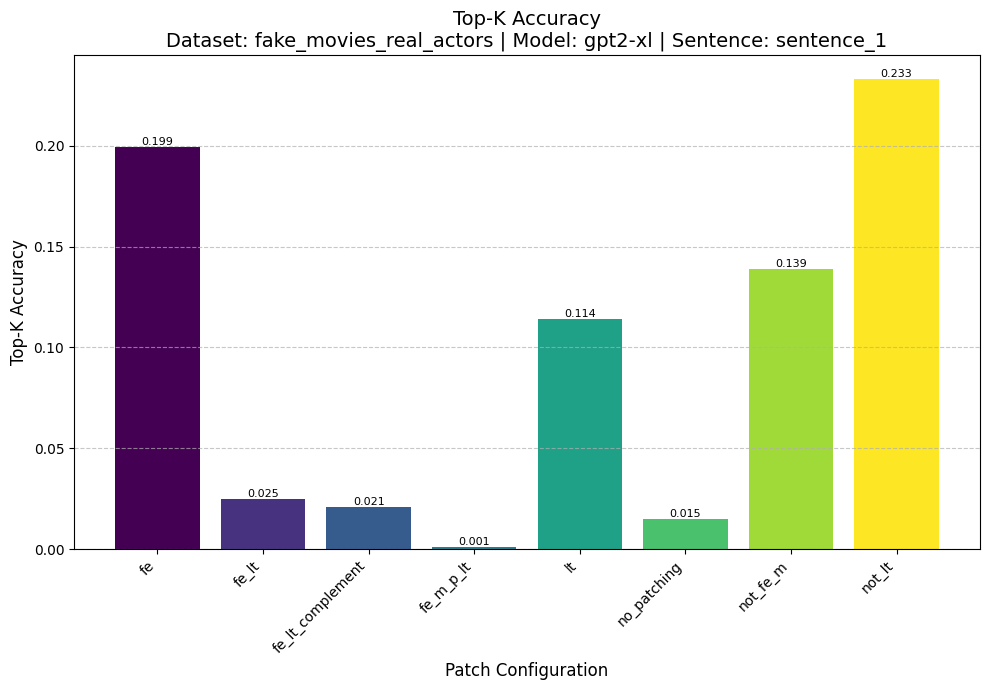

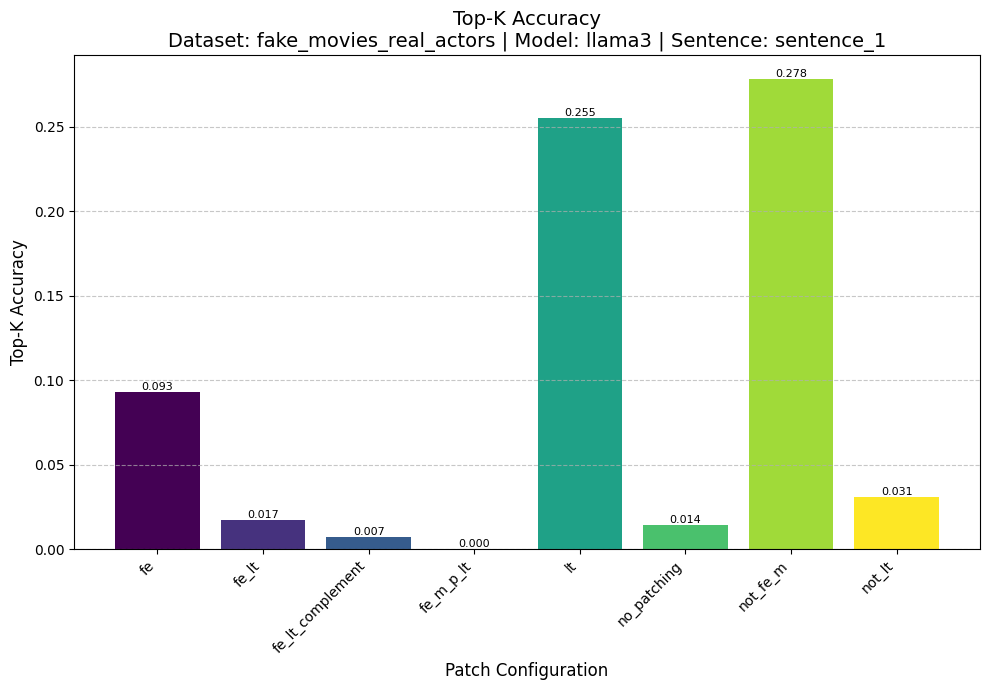

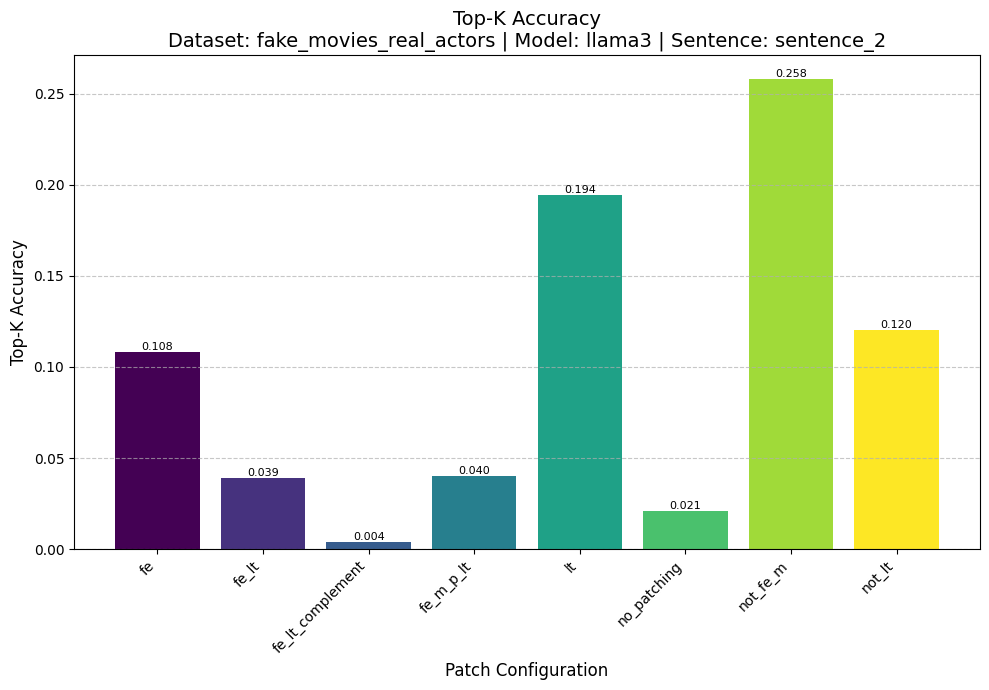

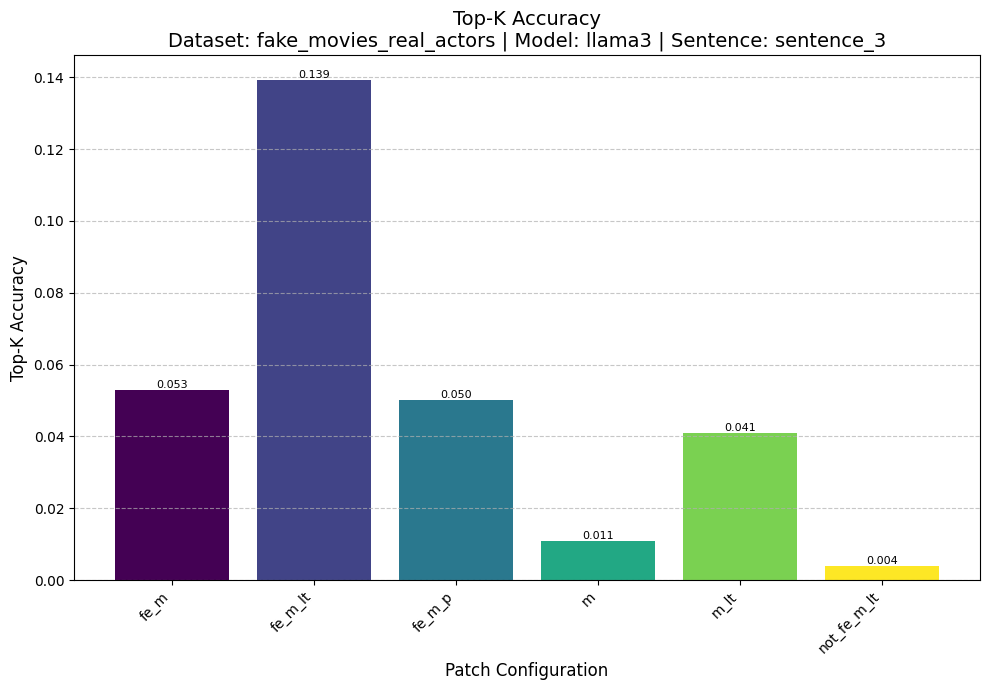

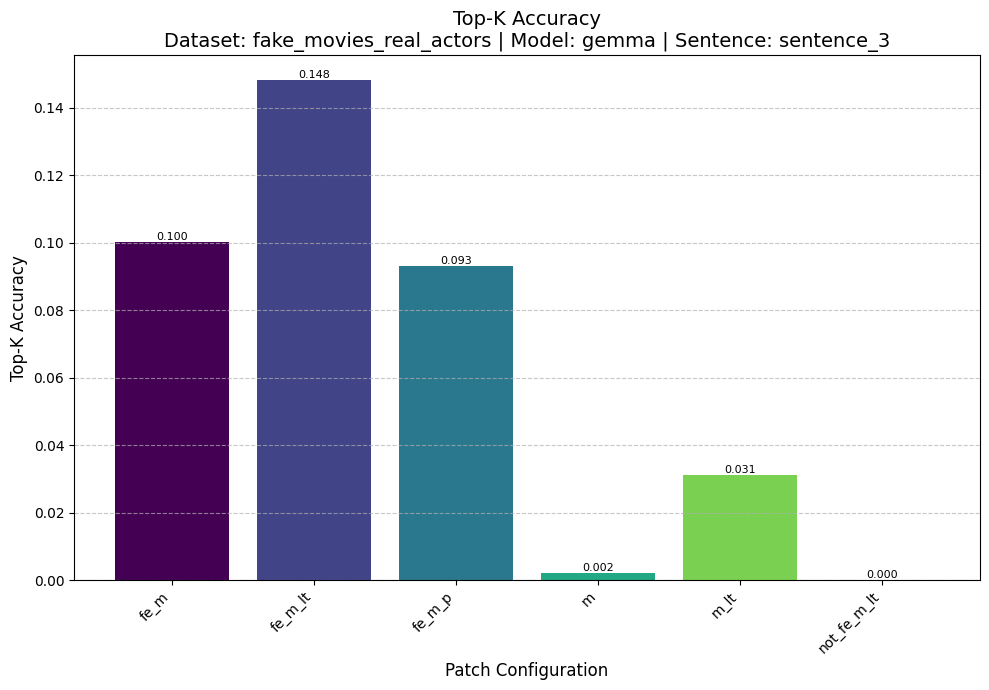

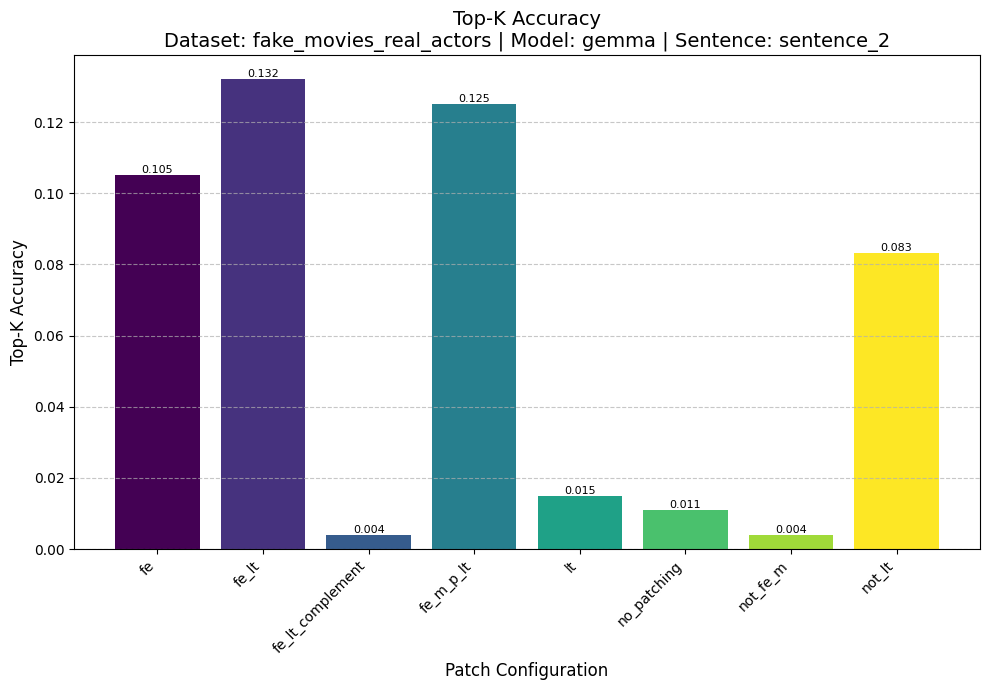

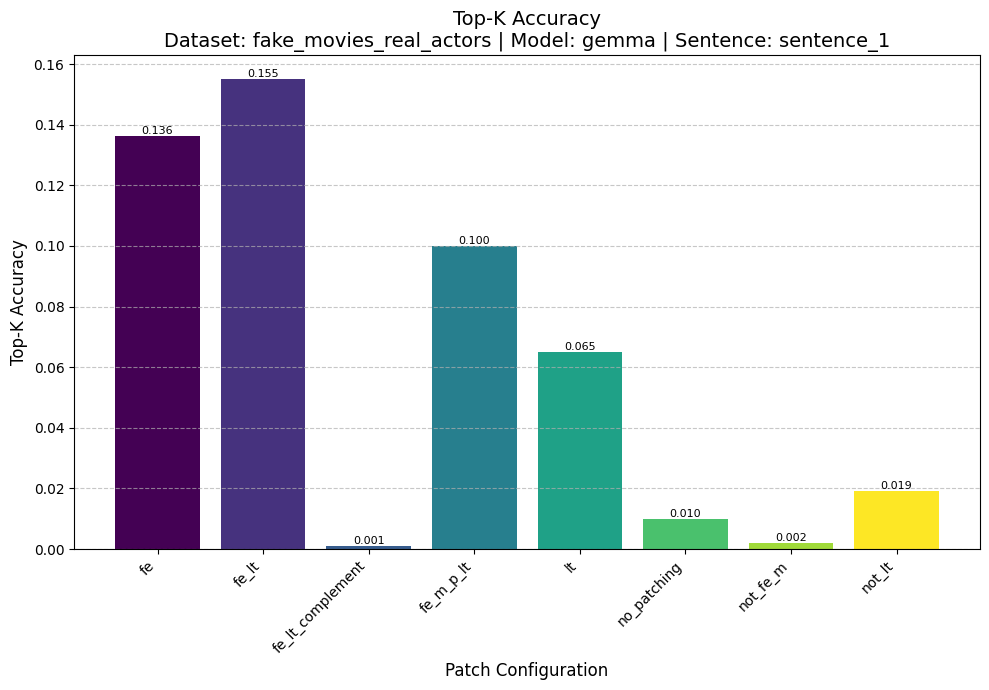

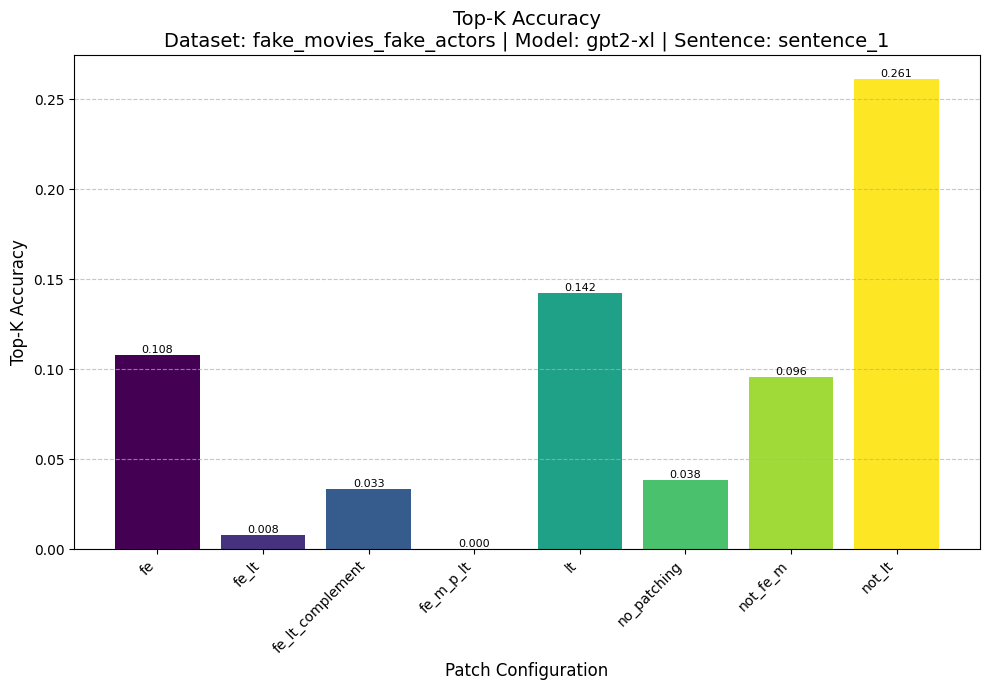

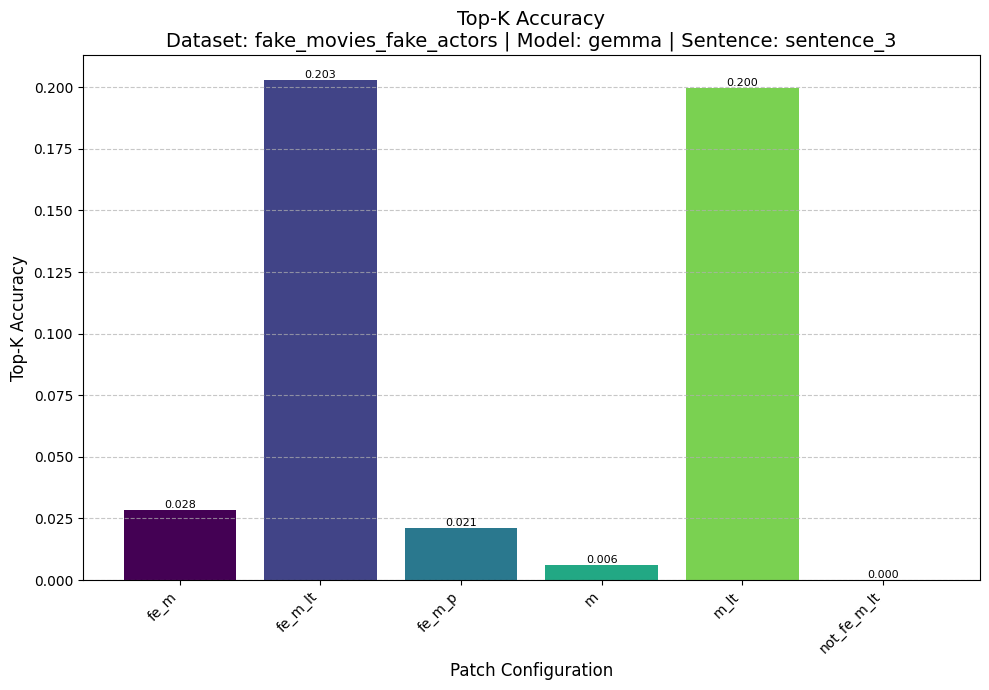

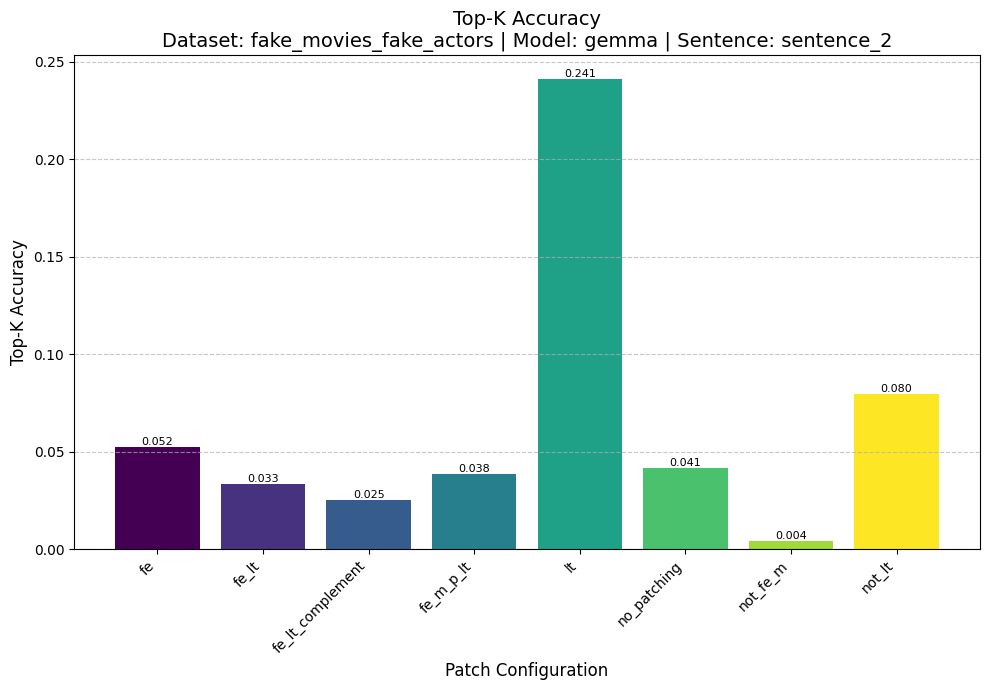

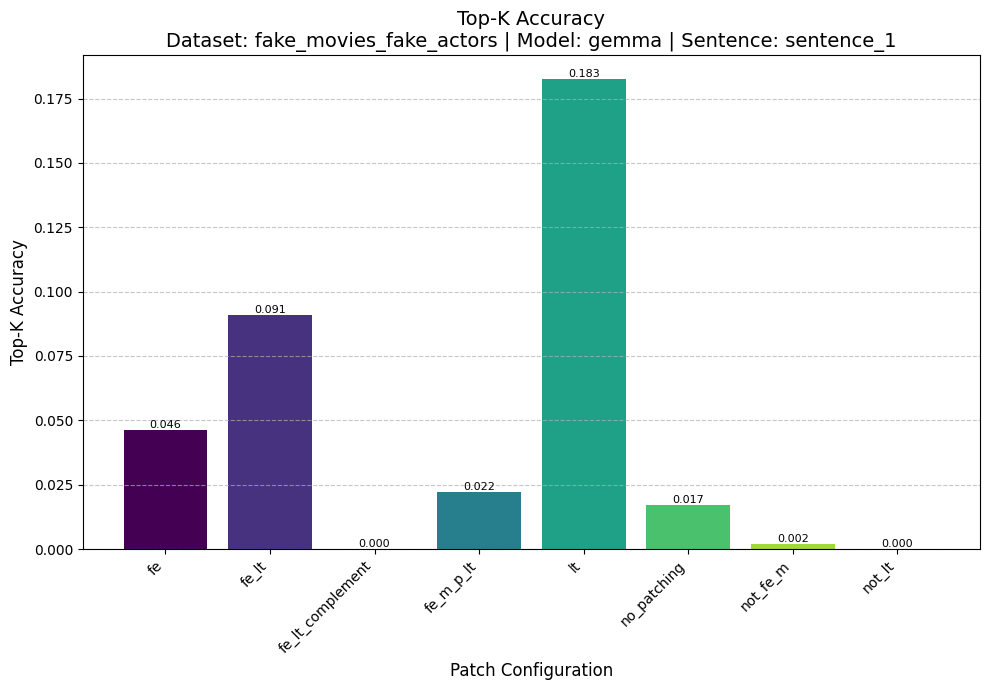

In [64]:
plot_topk_accuracy(data_by_sentence)

In [ ]:
for s_idx, sentence_template in enumerate(test_sentences):
    if s_idx not in results_dict:
        continue

    # Collect means for average ranks
    means = {}
    for patch_filename, results in results_dict[s_idx].items():
        target_ranks = results["target_token_ranks"]
        mean_rank = sum(target_ranks) / len(target_ranks) if target_ranks else 0
        means[patch_filename] = mean_rank
    
    # Plot
    colors = plt.cm.viridis(np.linspace(0, 1, len(means)))
    plt.figure(figsize=(10, 6))
    plt.bar(means.keys(), means.values(), color=colors)
    plt.title(f"Mean Target Token Rank for {sentence_template}")
    plt.xlabel("Patch Config")
    plt.ylabel("Mean Target Token Rank")
    plt.xticks(rotation=90)
    plt.show()